<a href="https://colab.research.google.com/github/PavanDaniele/drone-person-detection/blob/main/model_Training_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up: mount drive + import libraries

**Important Information:** We need to activate the GPU on Colab (_Runtime --> Change runtime type_). \
Every time you start a new session (or reopen the notebook after a few hours) check that the GPU is still active. If we are not using the GPU it can take up to tens of hours to train the models. \
_GPU T4 is the best choice._

In [ ]:
# Run this Every time you start a new session
from google.colab import drive
drive.mount('/content/drive') # to mount google drive (to see/access it)

Mounted at /content/drive


In [ ]:
!pip install ultralytics # Installation of Ultralytics for YOLO models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 110.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from ultralytics import YOLO # Import of Ultralytics for YOLO models

In [ ]:
import shutil
import os
from PIL import Image

# Import base for EfficientDet:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision import transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2

from effdet.efficientdet import HeadNet
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.bench import unwrap_bench
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from torchvision import transforms
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# General Explanation

### Backbone

In Computer Vision, a _Backbone_ is the part of a convolutional neural network responsible for extracting the main features from an image. \
It serves as the shared base upon which subsequent modules are built (such as heads for classification, object detection, segmentation, etc.).

\
Each backbone has been pre-trained on specific datasets (e.g., ImageNet) using particular preprocessing steps, input dimensions, normalization, and augmentation techniques, which should ideally be replicated during fine-tuning to maintain compatibility and achieve optimal performance.

### Data Loader

To train a deep learning model, it is essential to properly handle data loading and preparation. This is the task of the _Data Loader_, a component responsible for:
- Loading images and their corresponding annotations (e.g., .txt or .json) from the dataset.
- Applying preprocessing operations, such as resizing, normalization, data augmentation, etc.
- Organizing data into batches to feed the model during training.

\
Considering the limited resources of my development environment, at first I decided to perform the image and annotation resizing in a separate phase (prior to training), in order to:
- Reduce the workload of the data loader during fine-tuning;
- Increase data loading and training speed;
- Ensure consistency between images and annotations.

But due to the different type of scaling technique, I want to try to fine-tuning the model without any pre-scaling.

The other transformations, instead, are handled by the model-specific data loader, since each model uses different preprocessing and normalization techniques. \
Moreover, some models require specific transformations to achieve optimal performance, and the libraries that provide the models (e.g., Ultralytics for YOLO, torchvision for EfficientDet/SSD) already implement loaders that are properly configured and optimized.

### Normalization

Image normalization consists in scaling pixel values from the range [0, 255] to a more suitable interval (e.g., [0, 1] or [-1, 1]), often based on the mean and standard deviation of the pre-training dataset, with the goal of:
- Avoiding overly large values in the tensors;
- Making the model more stable during training;
- Speeding up convergence.

\
Normalization helps maintain a consistent pixel range and distribution, which is essential for pre-trained models.

### Data Augmentations

Data augmentation consists of random transformations (e.g., rotations, flips, crops, brightness changes, etc.) applied during training. Their purpose is to:
- Simulate new visual conditions;
- Increase dataset variety;
- Reduce overfitting by improving the model’s ability to generalize.

\
In practice, the semantic content of the image doesn't change (e.g., a person remains a person), but its visual appearance is altered to help the model "learn better."


My goal is to evaluate the real-world performance of each model in its ideal scenario, in order to select the most suitable one for deployment on the Jetson Nano. \
For this reason, each model is trained using its native augmentations, meaning the ones that were designed and optimized as part of its original architecture. \
It wouldn’t make sense to disable them or enforce a uniform setup across models, because what we want to observe is the maximum potential of each model, working in the way it was designed to perform best.

# Fine-Tuning Model

### YOLOv8n

First of all we need to save the dataset locally:


In [ ]:
src = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n'
dst = '/content/AERALIS_YOLOv8n_local'  # is now on the local VM, NOT on drive

# If the destination folder already exists, I delete it
if os.path.exists(dst):
  shutil.rmtree(dst)

# Recursive copy of ENTIRE folder (and subfolders)
shutil.copytree(src, dst)
print("Copy completed:", os.path.exists(dst))

Copy completed: True


Let's check the total free space:

In [ ]:
!df -h / # It shows the total, used and free space on the root (/) of the Colab VM.

# Avail column: space still available for your files.

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   56G   58G  49% /


In [ ]:
# Show space used by your local folder
!du -sh /content/AERALIS_YOLOv8n_local

6.6G	/content/AERALIS_YOLOv8n_local


In [ ]:
# Show space occupied by various folders in /content/.
!du -h --max-depth=1 /content/

140K	/content/.config
du: cannot access '/content/drive/.Encrypted/.shortcut-targets-by-id/1LQbD7p_iS5KLqGNdfrYEvsAx0i_bgB0h/projectUPV': No such file or directory
67G	/content/drive
6.6G	/content/AERALIS_YOLOv8n_local
31M	/content/runs_finetune
55M	/content/sample_data
74G	/content/


We want to create the data.yaml file, which YOLO uses to know:
- the path to the training, validation, and test images
- the number of classes (nc)
- the names of the classes (names)

\
This file is used by YOLO to locate the images and their annotations.

In [ ]:
# YAML dataset (edit routes)
data_yaml = """
train: /content/AERALIS_YOLOv8n_local/train/images
val:   /content/AERALIS_YOLOv8n_local/val/images
test:  /content/AERALIS_YOLOv8n_local/test/images

nc: 1
names: ['person']
"""
open('data.yaml', 'w').write(data_yaml)

176

Perfect, we have correctly written the data.yaml file for the AERALIS_YOLOv8n dataset. Let's continue with the loading of the model:

In [ ]:
# Upload the pre-trained model we want to use as a starting point

model_YOLOv8n = YOLO('yolov8n.pt') # it is the model that will be fine-tuned on the custom dataset

We have now downloaded the pre-trained model from the official Ultralytics repository.

The **Batch size** is the number of images processed simultaneously in each training step. With 4-8GB of RAM, a batch size of 8 (or even less) is recommended, so we'll start with that value and reduce it if necessary.

**Early Stopping** is a technique that automatically stops the training process if the model stops improving after a certain number of epochs. This helps prevent overfitting and saves time.

**Workers** are the parallel processes used to load and preprocess data while the model is training. However, due to our limited resources, we’ll start with 2 workers, and if data loading errors occur, we'll reduce this number to 1 or even 0.


In [ ]:
# To see the available GPU
print(torch.cuda.is_available()) # True = you have GPU --> if False then use device='cpu'
print(torch.cuda.device_count()) # Name of GPU

# If True and at least 1, you can use device=0.
# If you don't have GPU: use device='cpu' (much slower).
# Locally (not Colab): check with nvidia-smi from terminal.

True
1


Now that we have confirmation that the GPU is active we can train the model:

In [ ]:
# Fine‑tuning
results_YOLOv8n = model_YOLOv8n.train(
  data='data.yaml', # use the newly created yaml file
  epochs=100, # Maximum number of training epochs
  imgsz=640, # Image input size (recommended for YOLO).
  batch=16,  # Batch size
  patience=20, # Early stopping if the metrics do not improve for 20 epochs
  workers=2, # Number of workers for the dataloader
  device=0, # Use GPU 0 (or put 'cpu' if you don't have GPU)
  # device='cpu',
  project='runs_finetune', # Folder where it will save the results of the experiments (the folder will be created automatically)
  name='person_yolov8n' # Subfolder/name specific to our experiment
)

# results -->  will contain metrics, logs, and the path of the best weights found during the training

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=person_yolov8n4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=True, prof

train: Scanning /content/AERALIS_YOLOv8n_local/train/labels.cache... 2395 images, 388 backgrounds, 0 corrupt: 100%|██████████| 2395/2395 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 901.0±20.7 MB/s, size: 2606.8 KB)


val: Scanning /content/AERALIS_YOLOv8n_local/val/labels.cache... 515 images, 75 backgrounds, 0 corrupt: 100%|██████████| 515/515 [00:00<?, ?it/s]


Plotting labels to runs_finetune/person_yolov8n4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs_finetune/person_yolov8n4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.03G      2.025      1.712      1.023         61        640: 100%|██████████| 150/150 [01:09<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.84it/s]


                   all        515       1258      0.728       0.54      0.593      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.03G       2.04      1.462      1.036         52        640: 100%|██████████| 150/150 [01:05<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


                   all        515       1258      0.713      0.505      0.537      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.03G      2.064      1.333      1.051         50        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.713      0.506       0.56      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.1G      2.013      1.301      1.046         39        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.78it/s]

                   all        515       1258      0.719      0.551      0.594       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.1G      2.005      1.235       1.04         45        640: 100%|██████████| 150/150 [01:06<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.83it/s]

                   all        515       1258      0.807      0.518      0.612      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.12G      1.969      1.188      1.033         37        640: 100%|██████████| 150/150 [01:06<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.85it/s]

                   all        515       1258      0.613       0.49      0.499       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.12G      1.943      1.184      1.027         47        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]


                   all        515       1258      0.728      0.567      0.613      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.14G      1.924      1.141      1.013         39        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.92it/s]

                   all        515       1258       0.74      0.536      0.613      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.14G      1.878       1.11     0.9923         40        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.84it/s]

                   all        515       1258      0.765      0.599       0.66      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.14G      1.859      1.072     0.9979         61        640: 100%|██████████| 150/150 [01:07<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]

                   all        515       1258      0.851      0.582       0.67      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.14G      1.861      1.068      0.997         40        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.86it/s]

                   all        515       1258      0.797      0.609      0.693      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.14G      1.791      1.034     0.9833         42        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.794      0.613      0.673      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.14G      1.773     0.9961     0.9758         47        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.85it/s]

                   all        515       1258      0.788      0.623      0.685      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.14G      1.769     0.9976     0.9777         36        640: 100%|██████████| 150/150 [01:06<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.84it/s]

                   all        515       1258      0.817      0.603       0.69      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.15G      1.774     0.9841     0.9741         61        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.775      0.632      0.693      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.15G      1.775     0.9779     0.9722         41        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.79it/s]

                   all        515       1258      0.808      0.642       0.71      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.17G      1.736      0.957     0.9694         61        640: 100%|██████████| 150/150 [01:05<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]

                   all        515       1258       0.84       0.64      0.722      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.17G      1.749     0.9632     0.9686         65        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.80it/s]

                   all        515       1258      0.827      0.626      0.712      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.19G      1.723     0.9329      0.961         66        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.815      0.643      0.713      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.19G      1.689     0.9235     0.9546         29        640: 100%|██████████| 150/150 [01:07<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]

                   all        515       1258      0.842      0.661      0.732      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.19G      1.698     0.9341     0.9538         65        640: 100%|██████████| 150/150 [01:06<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.84it/s]

                   all        515       1258      0.839      0.647      0.739      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.19G      1.696     0.9209     0.9524         39        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.846      0.648      0.741      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.28G      1.663     0.9109     0.9496         42        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]

                   all        515       1258      0.873      0.643      0.752      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.28G      1.648     0.8686     0.9518         57        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        515       1258      0.809      0.668      0.747      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.28G      1.629     0.8655     0.9397         44        640: 100%|██████████| 150/150 [01:05<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.84it/s]

                   all        515       1258      0.858      0.691       0.77      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.28G      1.636     0.8714     0.9447         65        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.79it/s]

                   all        515       1258      0.869      0.682      0.779       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.28G      1.625     0.8701     0.9404         52        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]

                   all        515       1258       0.82      0.676      0.755      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.28G      1.623     0.8511     0.9372         42        640: 100%|██████████| 150/150 [01:07<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.84it/s]

                   all        515       1258      0.841      0.684      0.773      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.28G       1.61     0.8552     0.9404         55        640: 100%|██████████| 150/150 [01:06<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.846      0.689      0.768      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.28G      1.597     0.8364     0.9339         36        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.859      0.693       0.77      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.28G      1.578     0.8265     0.9351         49        640: 100%|██████████| 150/150 [01:07<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]

                   all        515       1258      0.851      0.689      0.774      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.28G      1.584     0.8297     0.9363         56        640: 100%|██████████| 150/150 [01:05<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.74it/s]

                   all        515       1258      0.854      0.684       0.77      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.28G      1.589     0.8483     0.9337         44        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.856       0.71      0.793      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.28G      1.543     0.8078     0.9247         55        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.85it/s]

                   all        515       1258      0.827      0.699      0.777      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.28G      1.557     0.8229     0.9245         31        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.854      0.715       0.79      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.28G       1.56     0.8033     0.9244         32        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        515       1258      0.861      0.722      0.802      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.28G      1.536     0.7947     0.9257         47        640: 100%|██████████| 150/150 [01:07<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.86it/s]

                   all        515       1258      0.882        0.7      0.794       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.28G      1.515     0.7877     0.9102         47        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.845      0.721      0.797      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.28G      1.523     0.7687     0.9156         68        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.85it/s]

                   all        515       1258      0.868       0.71      0.798      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.28G      1.519     0.7921     0.9201         42        640: 100%|██████████| 150/150 [01:06<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]

                   all        515       1258      0.875      0.684      0.785      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.28G      1.497     0.7757     0.9225         40        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        515       1258      0.851      0.719      0.801      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.28G      1.496     0.7626     0.9123         52        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]

                   all        515       1258       0.87      0.728      0.809      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.28G      1.511     0.7667     0.9127         44        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.852      0.726      0.804      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.28G      1.516     0.7719     0.9157        102        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.868      0.734      0.817       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.28G      1.495     0.7586     0.9097         66        640: 100%|██████████| 150/150 [01:06<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]

                   all        515       1258      0.866      0.731      0.814      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.28G      1.482     0.7577     0.9089         31        640: 100%|██████████| 150/150 [01:05<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]

                   all        515       1258      0.868       0.75      0.823      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.28G      1.476     0.7516     0.9117         41        640: 100%|██████████| 150/150 [01:06<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.79it/s]

                   all        515       1258      0.871      0.734      0.812      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.28G      1.466     0.7448     0.9066         40        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]

                   all        515       1258      0.854      0.732      0.803      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.28G      1.463     0.7505     0.9063         34        640: 100%|██████████| 150/150 [01:06<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.83it/s]

                   all        515       1258      0.875      0.742      0.823      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.38G      1.447     0.7293     0.8971         24        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.872      0.726      0.817      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.38G      1.421     0.7202     0.9023         59        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258       0.84      0.724      0.806      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.38G      1.444      0.722     0.9002         31        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.866      0.712      0.806      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.38G      1.442      0.726     0.8949         51        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]

                   all        515       1258      0.876      0.729      0.827      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.38G      1.444     0.7267     0.8971         50        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.873      0.733       0.82      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.38G      1.419     0.7161     0.8971         29        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        515       1258       0.85      0.753      0.824      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.38G      1.413     0.7102     0.8993         44        640: 100%|██████████| 150/150 [01:06<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]

                   all        515       1258       0.87      0.746       0.83      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.38G      1.413     0.7024     0.9053         36        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        515       1258      0.879      0.753      0.828      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.38G      1.384     0.6933     0.8941         80        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        515       1258      0.875      0.724      0.814      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.38G      1.398     0.6965     0.8937         29        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.80it/s]

                   all        515       1258      0.876      0.749      0.834       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.38G      1.376       0.69     0.8971         60        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]

                   all        515       1258       0.87      0.746      0.827      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.38G      1.382     0.6847     0.8938         41        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        515       1258      0.873      0.732       0.82      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.38G       1.39     0.6894     0.8923         32        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.86it/s]

                   all        515       1258      0.868      0.742      0.822      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.38G      1.362     0.6772     0.8889         64        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.83it/s]

                   all        515       1258      0.859      0.728      0.812      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.38G      1.378     0.6752     0.8906         63        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.873      0.731      0.825      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.38G      1.344     0.6669     0.8851         43        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.85it/s]

                   all        515       1258      0.866      0.751      0.834      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.38G      1.349     0.6609     0.8864         72        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]

                   all        515       1258      0.856      0.756      0.828      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.38G      1.333     0.6547     0.8763         56        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        515       1258      0.889      0.746      0.837      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.48G      1.354     0.6614     0.8842         39        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.881       0.73      0.829      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.48G       1.33     0.6526      0.883         55        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.884      0.739      0.833      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.48G      1.318     0.6449     0.8754         28        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.861      0.762      0.836      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.48G      1.324     0.6467     0.8785         22        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.862      0.759      0.832      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.48G      1.321      0.648     0.8729         58        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]

                   all        515       1258      0.874      0.741      0.832      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.48G      1.308     0.6405     0.8755         50        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]

                   all        515       1258      0.871      0.754      0.835      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.48G      1.314     0.6406     0.8758         49        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.893       0.75      0.844      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.48G      1.309     0.6383     0.8745         43        640: 100%|██████████| 150/150 [01:05<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.893      0.753      0.845      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.48G      1.285     0.6355      0.877         31        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.882      0.762      0.841      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.48G      1.303     0.6355     0.8734         45        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258       0.86      0.758      0.839      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.48G      1.302     0.6324     0.8725         29        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        515       1258      0.886      0.745      0.834      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.48G      1.273      0.617     0.8774         44        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]

                   all        515       1258      0.872      0.755      0.843      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.48G      1.279      0.616     0.8718         42        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.85it/s]

                   all        515       1258      0.884      0.754      0.843       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.48G      1.264     0.6098     0.8733         65        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.80it/s]

                   all        515       1258      0.875      0.767      0.845       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.48G      1.257     0.6066     0.8662         49        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258       0.86      0.782      0.849       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.48G      1.269     0.6173     0.8651         40        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]

                   all        515       1258       0.89      0.754       0.84      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.48G      1.272     0.6106     0.8697         66        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.886      0.763      0.846      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.48G      1.248     0.6054     0.8662         40        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258       0.88      0.769      0.856      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.48G      1.233     0.5921     0.8635         50        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.872      0.764      0.844      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.48G      1.258     0.6098     0.8646         43        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.876      0.769      0.855      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.48G      1.245     0.6047     0.8615         42        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.85it/s]

                   all        515       1258      0.886      0.761      0.852      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.48G      1.241     0.6014     0.8658         43        640: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.92it/s]

                   all        515       1258        0.9      0.759      0.854      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.48G      1.227     0.5937     0.8615         28        640: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.902      0.756      0.856      0.473


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.48G      1.246     0.6033     0.8731         22        640: 100%|██████████| 150/150 [01:07<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:06<00:00,  2.80it/s]

                   all        515       1258      0.874      0.771      0.847      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.48G      1.227     0.5855     0.8642         36        640: 100%|██████████| 150/150 [01:04<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.86it/s]

                   all        515       1258      0.886      0.762      0.851      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.48G        1.2      0.576     0.8624         23        640: 100%|██████████| 150/150 [01:04<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]

                   all        515       1258      0.852      0.787      0.853      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.48G      1.188     0.5708     0.8609         35        640: 100%|██████████| 150/150 [01:04<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]

                   all        515       1258      0.872      0.783      0.859      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.48G      1.199      0.571     0.8616         23        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]

                   all        515       1258      0.904      0.757      0.853      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.48G      1.192     0.5721     0.8664         18        640: 100%|██████████| 150/150 [01:05<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.84it/s]

                   all        515       1258        0.9      0.758      0.851      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.48G      1.173     0.5639      0.856         21        640: 100%|██████████| 150/150 [01:04<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.887       0.77      0.856      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.48G      1.161     0.5505     0.8515         32        640: 100%|██████████| 150/150 [01:04<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.91it/s]

                   all        515       1258      0.905       0.77      0.861      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.48G       1.16     0.5538     0.8518         29        640: 100%|██████████| 150/150 [01:05<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.89it/s]

                   all        515       1258      0.908      0.761      0.855      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.48G      1.154     0.5461     0.8617         15        640: 100%|██████████| 150/150 [01:04<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.86it/s]

                   all        515       1258      0.896      0.769      0.857      0.481



100 epochs completed in 2.009 hours.
Optimizer stripped from runs_finetune/person_yolov8n4/weights/last.pt, 6.2MB
Optimizer stripped from runs_finetune/person_yolov8n4/weights/best.pt, 6.2MB

Validating runs_finetune/person_yolov8n4/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]


                   all        515       1258      0.905      0.771      0.861      0.482
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs_finetune/person_yolov8n4


We now want to evaluate the trained model using the Test set defined in data.yaml. \
YOLO does not compute standard accuracy, because in object detection True Negatives (TN) are not counted. Therefore, traditional accuracy is not applicable or useful.


So, we will compute:
- **Precision**: how correct your detected positives are
- **Recall**: how many of the real objects you detected
- **mAP50**: mean Average Precision with IoU ≥ 0.5 (how accurate the predictions are)
- **mAP50-95**: average over various IoU thresholds, a more strict metric
- **F1_score**: combination of precision and recall (you can compute it as: 2 * (P * R) / (P + R))

In [ ]:
# Evaluates the trained model using the TEST SET defined in data.yaml

metrics_YOLOv8n = model_YOLOv8n.val(data='data.yaml', split='test') # returns accuracy metrics (e.g., mAP, precision, recall, etc.) on the test set
print("Test metrics:", metrics_YOLOv8n)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 80.0±11.5 MB/s, size: 1605.8 KB)


val: Scanning /content/AERALIS_YOLOv8n_local/test/labels... 516 images, 93 backgrounds, 0 corrupt: 100%|██████████| 516/516 [00:01<00:00, 505.99it/s]

val: New cache created: /content/AERALIS_YOLOv8n_local/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.10it/s]


                   all        516       1271      0.905      0.829      0.904      0.506
Speed: 0.3ms preprocess, 1.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs_finetune/person_yolov8n42
Test metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d498713b390>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031

Confidence (confidence) is the probability estimated by the model that a detected object is actually real (i.e., not a false positive).

In [ ]:
#  Inference (practical use of the fine-tuned model)

# Load the best weights found
best_YOLOv8n = '/content/runs_finetune/person_yolov8n2/weights/best.pt'
model_inf_YOLOv8n = YOLO(best_YOLOv8n) # Creates a new model instance by loading the best weights

# Performs inference on one or more images, or on a video, by specifying the path in the source parameter.
# conf=0.25 → Confidence threshold for considering a detection valid.
preds_YOLOv8n = model_inf_YOLOv8n.predict(
  # source='/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/test/images',
  source='/content/AERALIS_YOLOv8n_local/test/images',
  conf=0.25,
  verbose=False, # disable on-screen printing
  save=True
)

# Too many images to show!
# for result in preds_YOLOv8n:
#    result.show() # displays the predictions (eventually you can also save them)

Results saved to runs/detect/predict


In order to use it on the Jetson Nano we now want to download the model, so:

In [ ]:
# Create folders on Google Drive (first time only):
!mkdir -p /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/results/annotated
!mkdir -p /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/weights

In [ ]:
# Copy annotated images:
!cp -r /content/runs/detect/predict/* /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/results/annotated/

# Copy the best weights (best.pt) after training:
!cp /content/runs_finetune/person_yolov8n2/weights/best.pt /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/weights/

In [ ]:
# To download it directly to the computer:
from google.colab import files
files.download('/content/runs_finetune/person_yolov8n/weights/best.pt')

When we have the .pt file on the PC, we could:
- Upload it to the Jetson Nano,
- Convert it to ONNX/TensorRT if you need it for optimization,
- Use it with the PyTorch/Ultralytics version on any computer.

Weight access code

In [ ]:
# Path of saved weights:
weights_path_YOLOv8n = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/weights/best.pt'
model_YOLOv8n = YOLO(weights_path_YOLOv8n)

Access code for annotated images

In [ ]:
# Directory of annotated images
annotated_dir = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv8n/results/annotated'

# Get all the .jpg files in the directory
annotated_imgs_YOLOv8n = [
  os.path.join(annotated_dir, f)
  for f in os.listdir(annotated_dir)
  if f.lower().endswith('.jpg')
]

# View the first 5 annotated images
for img_path in annotated_imgs_YOLOv8n[:5]:
  img = Image.open(img_path)
  img.show()

### YOLOv11n

Ora eseguiamo lo stesso procedimento per YOLOv11n:

In [ ]:
src = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n'
dst = '/content/AERALIS_YOLOv11n_local'  # is now on the local VM, NOT on drive

# If the destination folder already exists, I delete it
if os.path.exists(dst):
  shutil.rmtree(dst)

# Recursive copy of ENTIRE folder (and subfolders)
shutil.copytree(src, dst)
print("Copy completed:", os.path.exists(dst))

Copy completed: True


In [ ]:
!df -h / # It shows the total, used and free space on the root (/) of the Colab VM.

# Avail column: space still available for your files.

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   55G   58G  49% /


In [ ]:
# Show space used by your local folder
!du -sh /content/AERALIS_YOLOv11n_local

6.6G	/content/AERALIS_YOLOv11n_local


In [ ]:
# Show space occupied by various folders in /content/.
!du -h --max-depth=1 /content/

140K	/content/.config
6.6G	/content/AERALIS_YOLOv11n_local
du: cannot access '/content/drive/.Encrypted/.shortcut-targets-by-id/1LQbD7p_iS5KLqGNdfrYEvsAx0i_bgB0h/projectUPV': No such file or directory
69G	/content/drive
55M	/content/sample_data
75G	/content/


In [ ]:
# YAML dataset (edit routes)
data_yaml = """
train: /content/AERALIS_YOLOv11n_local/train/images
val:   /content/AERALIS_YOLOv11n_local/val/images
test:  /content/AERALIS_YOLOv11n_local/test/images

nc: 1
names: ['person']
"""
open('data.yaml', 'w').write(data_yaml)

179

In [ ]:
# Upload the pre-trained model we want to use as a starting point

model_YOLOv11n = YOLO('yolo11n.pt') # it is the model that will be fine-tuned on the custom dataset

100%|██████████| 5.35M/5.35M [00:00<00:00, 78.4MB/s]


In [ ]:
# To see the available GPU
import torch
print(torch.cuda.is_available()) # True = you have GPU --> if False then use device='cpu'
print(torch.cuda.device_count()) # Name of GPU

# If True and at least 1, you can use device=0.
# If you don't have GPU: use device='cpu' (much slower).
# Locally (not Colab): check with nvidia-smi from terminal.

True
1


In [ ]:
# Fine‑tuning
results_YOLOv11n = model_YOLOv11n.train(
  data='data.yaml',
  epochs=100,
  imgsz=640,
  batch=16,
  patience=20,
  workers=2,
  device=0,
  project='runs_finetune',
  name='person_yolov11n'
)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=person_yolov11n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrained=True, prof

100%|██████████| 755k/755k [00:00<00:00, 19.5MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2916.3±1744.5 MB/s, size: 2026.4 KB)


train: Scanning /content/AERALIS_YOLOv11n_local/train/labels... 2395 images, 388 backgrounds, 0 corrupt: 100%|██████████| 2395/2395 [00:01<00:00, 1677.09it/s]

train: New cache created: /content/AERALIS_YOLOv11n_local/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4029.4±2087.3 MB/s, size: 2606.8 KB)


val: Scanning /content/AERALIS_YOLOv11n_local/val/labels... 515 images, 75 backgrounds, 0 corrupt: 100%|██████████| 515/515 [00:00<00:00, 1544.82it/s]

val: New cache created: /content/AERALIS_YOLOv11n_local/val/labels.cache


Plotting labels to runs_finetune/person_yolov11n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs_finetune/person_yolov11n
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.35G      2.228       3.31      1.089         61        640: 100%|██████████| 150/150 [01:14<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.99it/s]


                   all        515       1258      0.567      0.447      0.451      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.44G      2.186      1.962      1.079         52        640: 100%|██████████| 150/150 [01:15<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.31it/s]


                   all        515       1258      0.575      0.378      0.422      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.46G      2.179      1.566      1.088         50        640: 100%|██████████| 150/150 [01:13<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]


                   all        515       1258      0.669        0.5      0.537      0.208

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.47G      2.109      1.435      1.065         39        640: 100%|██████████| 150/150 [01:13<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258        0.7      0.508       0.55      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.49G      2.076      1.335      1.056         45        640: 100%|██████████| 150/150 [01:14<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.25it/s]

                   all        515       1258      0.713      0.541       0.58      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.5G      2.024      1.253      1.047         37        640: 100%|██████████| 150/150 [01:15<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.704       0.56      0.594      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.52G      1.993      1.258      1.039         47        640: 100%|██████████| 150/150 [01:10<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]

                   all        515       1258      0.694       0.49      0.542      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.53G      1.977      1.192      1.023         39        640: 100%|██████████| 150/150 [01:10<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.30it/s]

                   all        515       1258      0.721      0.561      0.602      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.55G      1.922      1.139      1.003         40        640: 100%|██████████| 150/150 [01:14<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.823      0.584      0.659      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.56G      1.894        1.1      1.005         61        640: 100%|██████████| 150/150 [01:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.787       0.58      0.651      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.58G      1.891      1.107     0.9989         40        640: 100%|██████████| 150/150 [01:10<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]

                   all        515       1258      0.786      0.591      0.647      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.59G      1.845      1.073     0.9877         42        640: 100%|██████████| 150/150 [01:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.30it/s]

                   all        515       1258       0.78        0.6      0.668      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.61G      1.833      1.058     0.9868         47        640: 100%|██████████| 150/150 [01:10<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]


                   all        515       1258      0.745      0.593      0.641      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.62G      1.818      1.042     0.9823         36        640: 100%|██████████| 150/150 [01:14<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.31it/s]

                   all        515       1258      0.772      0.626      0.685      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.64G      1.818      1.024     0.9825         61        640: 100%|██████████| 150/150 [01:08<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]

                   all        515       1258      0.769        0.6      0.665      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.65G      1.793      1.017     0.9739         41        640: 100%|██████████| 150/150 [01:12<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.814      0.605      0.698      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.67G      1.776      1.001     0.9732         61        640: 100%|██████████| 150/150 [01:10<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258       0.85      0.617      0.704      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.68G      1.784     0.9895     0.9729         65        640: 100%|██████████| 150/150 [01:09<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.794      0.617      0.691      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100       2.7G      1.765     0.9795     0.9651         66        640: 100%|██████████| 150/150 [01:10<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]

                   all        515       1258      0.789      0.616      0.677      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.71G      1.746     0.9641     0.9622         29        640: 100%|██████████| 150/150 [01:13<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.801      0.628      0.693      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.73G      1.743     0.9615     0.9586         65        640: 100%|██████████| 150/150 [01:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]

                   all        515       1258      0.816      0.626      0.721       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.74G      1.736     0.9486     0.9558         39        640: 100%|██████████| 150/150 [01:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258       0.82      0.621      0.703      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.75G      1.699     0.9304      0.953         42        640: 100%|██████████| 150/150 [01:10<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.805      0.656      0.724      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.77G      1.678     0.9007      0.954         57        640: 100%|██████████| 150/150 [01:09<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.808      0.656       0.74      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.79G      1.675     0.9041     0.9448         44        640: 100%|██████████| 150/150 [01:10<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.815      0.648      0.725      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       2.8G      1.682     0.9133     0.9542         65        640: 100%|██████████| 150/150 [01:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.31it/s]

                   all        515       1258      0.827      0.653      0.726      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.81G      1.683     0.9205      0.949         52        640: 100%|██████████| 150/150 [01:08<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.829      0.651      0.733      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.83G      1.666     0.8888     0.9442         42        640: 100%|██████████| 150/150 [01:11<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.835      0.657       0.74      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.84G      1.667     0.8914     0.9459         55        640: 100%|██████████| 150/150 [01:12<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.856      0.615      0.729      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.86G      1.632     0.8742     0.9386         36        640: 100%|██████████| 150/150 [01:09<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]

                   all        515       1258      0.838      0.665      0.737      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.87G      1.633     0.8677     0.9398         49        640: 100%|██████████| 150/150 [01:11<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.827      0.679      0.749      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.89G      1.627     0.8686     0.9434         56        640: 100%|██████████| 150/150 [01:14<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.818      0.645      0.712      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.9G      1.643     0.8805     0.9426         44        640: 100%|██████████| 150/150 [01:14<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]

                   all        515       1258      0.825      0.686      0.757      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.92G      1.585     0.8505     0.9295         55        640: 100%|██████████| 150/150 [01:11<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.827      0.693      0.764      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.93G      1.616     0.8578     0.9349         31        640: 100%|██████████| 150/150 [01:14<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.868      0.672      0.768      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.95G      1.611     0.8434     0.9296         32        640: 100%|██████████| 150/150 [01:10<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.23it/s]

                   all        515       1258      0.881      0.695      0.784      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.96G      1.585     0.8318      0.927         47        640: 100%|██████████| 150/150 [01:12<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.26it/s]

                   all        515       1258      0.873      0.696      0.788      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.98G      1.543     0.8215     0.9148         47        640: 100%|██████████| 150/150 [01:10<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.25it/s]

                   all        515       1258       0.86      0.703      0.788      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.99G      1.559     0.8074     0.9206         68        640: 100%|██████████| 150/150 [01:11<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.836      0.702      0.782      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.01G      1.568     0.8212     0.9258         42        640: 100%|██████████| 150/150 [01:16<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.838      0.702      0.776      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.02G      1.541     0.8131     0.9252         40        640: 100%|██████████| 150/150 [01:09<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258       0.85      0.693      0.781      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.04G      1.544     0.8065     0.9149         52        640: 100%|██████████| 150/150 [01:07<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.863      0.718      0.793      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.05G      1.568     0.8091     0.9157         44        640: 100%|██████████| 150/150 [01:13<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.847      0.724        0.8      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.07G      1.559     0.8103     0.9204        102        640: 100%|██████████| 150/150 [01:10<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.30it/s]

                   all        515       1258      0.881      0.713      0.797      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.08G      1.539     0.7987     0.9149         66        640: 100%|██████████| 150/150 [01:12<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.858      0.734      0.809      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100       3.1G       1.53      0.787      0.914         31        640: 100%|██████████| 150/150 [01:10<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.882      0.712      0.794      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.11G      1.514      0.794     0.9142         41        640: 100%|██████████| 150/150 [01:09<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.896      0.721      0.812      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.12G      1.515     0.7785     0.9114         40        640: 100%|██████████| 150/150 [01:11<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.867      0.707      0.806      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.14G      1.501     0.7769     0.9083         34        640: 100%|██████████| 150/150 [01:10<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.895      0.719      0.813      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.15G      1.493     0.7717     0.9041         24        640: 100%|██████████| 150/150 [01:11<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258       0.86      0.742      0.815      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.17G       1.46     0.7535     0.9024         59        640: 100%|██████████| 150/150 [01:07<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.873       0.72        0.8       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.19G      1.497     0.7668     0.9075         31        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.25it/s]

                   all        515       1258      0.882      0.713      0.806      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100       3.2G      1.479      0.756     0.8978         51        640: 100%|██████████| 150/150 [01:07<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.857      0.729      0.805      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.21G      1.501     0.7605     0.9015         50        640: 100%|██████████| 150/150 [01:11<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.874      0.734      0.813      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.23G       1.47      0.751      0.905         29        640: 100%|██████████| 150/150 [01:08<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258       0.87      0.738      0.809      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.25G       1.46     0.7459     0.9024         44        640: 100%|██████████| 150/150 [01:09<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.884      0.721      0.822      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.26G      1.462     0.7434     0.9085         36        640: 100%|██████████| 150/150 [01:05<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.37it/s]

                   all        515       1258      0.914      0.736       0.83      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.27G      1.426     0.7235     0.8973         80        640: 100%|██████████| 150/150 [01:08<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.872      0.756      0.833      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.29G      1.457     0.7424      0.898         29        640: 100%|██████████| 150/150 [01:07<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.886      0.738      0.821      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100       3.3G      1.431     0.7284     0.9055         60        640: 100%|██████████| 150/150 [01:07<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.869       0.75      0.824      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.32G      1.445     0.7245     0.9006         41        640: 100%|██████████| 150/150 [01:15<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]

                   all        515       1258      0.877      0.757      0.828      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.33G      1.438     0.7284     0.8974         32        640: 100%|██████████| 150/150 [01:12<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.903      0.748       0.83      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.35G      1.401     0.7099     0.8905         64        640: 100%|██████████| 150/150 [01:08<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.871      0.752       0.83      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.36G      1.428     0.7143     0.8919         63        640: 100%|██████████| 150/150 [01:08<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.886      0.749      0.828      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.38G      1.396     0.7025     0.8887         43        640: 100%|██████████| 150/150 [01:12<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]

                   all        515       1258       0.87       0.76      0.827      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.39G      1.397     0.6991     0.8898         72        640: 100%|██████████| 150/150 [01:10<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]

                   all        515       1258      0.875      0.767       0.84      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.41G      1.396     0.6988     0.8843         56        640: 100%|██████████| 150/150 [01:12<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.896       0.73      0.829      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.52G      1.411      0.706     0.8928         39        640: 100%|██████████| 150/150 [01:11<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.862      0.757      0.832      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.54G      1.381     0.6903     0.8856         55        640: 100%|██████████| 150/150 [01:07<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.30it/s]

                   all        515       1258      0.855      0.767      0.837      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.55G      1.365     0.6799     0.8802         28        640: 100%|██████████| 150/150 [01:10<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]

                   all        515       1258       0.86       0.77      0.838      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.57G      1.378     0.6846     0.8813         22        640: 100%|██████████| 150/150 [01:08<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.878      0.754      0.837      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.58G      1.371     0.6867     0.8768         58        640: 100%|██████████| 150/150 [01:08<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.873      0.743      0.831      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100       3.6G      1.365     0.6794     0.8799         50        640: 100%|██████████| 150/150 [01:14<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.888      0.749      0.835      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.61G      1.372     0.6757     0.8817         49        640: 100%|██████████| 150/150 [01:11<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]

                   all        515       1258      0.886      0.748       0.84      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.63G      1.364     0.6763     0.8801         43        640: 100%|██████████| 150/150 [01:11<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]

                   all        515       1258        0.9      0.756      0.844      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.64G      1.348     0.6725     0.8807         31        640: 100%|██████████| 150/150 [01:09<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]

                   all        515       1258      0.886       0.75      0.839      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.66G      1.368     0.6758     0.8816         45        640: 100%|██████████| 150/150 [01:07<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.895      0.761      0.842      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.67G      1.359     0.6749     0.8766         29        640: 100%|██████████| 150/150 [01:07<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.885      0.762      0.853      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.69G       1.33     0.6528     0.8795         44        640: 100%|██████████| 150/150 [01:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.861      0.779      0.845      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100       3.7G      1.333     0.6557      0.877         42        640: 100%|██████████| 150/150 [01:10<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.891       0.75      0.846      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.72G      1.323     0.6499     0.8796         65        640: 100%|██████████| 150/150 [01:15<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]

                   all        515       1258       0.89      0.782      0.853      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.73G      1.308     0.6427      0.871         49        640: 100%|██████████| 150/150 [01:11<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.881      0.777      0.856      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.75G      1.336     0.6552     0.8717         40        640: 100%|██████████| 150/150 [01:09<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.892      0.769       0.85      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.76G      1.327     0.6514     0.8741         66        640: 100%|██████████| 150/150 [01:08<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.31it/s]

                   all        515       1258      0.882       0.77      0.849      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.78G      1.308     0.6499     0.8738         40        640: 100%|██████████| 150/150 [01:12<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.896      0.762      0.849      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.79G      1.298     0.6292     0.8691         50        640: 100%|██████████| 150/150 [01:13<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.892      0.762      0.847      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       3.8G      1.311     0.6404     0.8697         43        640: 100%|██████████| 150/150 [01:13<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.888      0.762      0.847      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.82G        1.3      0.639     0.8654         42        640: 100%|██████████| 150/150 [01:10<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.888      0.775      0.855      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.83G      1.313     0.6388     0.8733         43        640: 100%|██████████| 150/150 [01:10<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]

                   all        515       1258      0.907      0.761      0.861      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.85G      1.278     0.6316     0.8672         28        640: 100%|██████████| 150/150 [01:09<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]

                   all        515       1258      0.886      0.778      0.859      0.479


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.86G      1.308      0.642     0.8773         22        640: 100%|██████████| 150/150 [01:18<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.30it/s]

                   all        515       1258       0.88      0.781      0.856      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.88G      1.287     0.6271     0.8715         36        640: 100%|██████████| 150/150 [01:15<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.878      0.775      0.848      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.89G       1.26     0.6184      0.867         23        640: 100%|██████████| 150/150 [01:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.882      0.777      0.856      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.91G      1.247     0.6136     0.8653         35        640: 100%|██████████| 150/150 [01:13<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.28it/s]

                   all        515       1258      0.886      0.772      0.854      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.92G      1.252     0.6071     0.8662         23        640: 100%|██████████| 150/150 [01:16<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]

                   all        515       1258      0.884      0.771      0.855      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.94G      1.262     0.6115     0.8725         18        640: 100%|██████████| 150/150 [01:15<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.31it/s]

                   all        515       1258      0.878      0.782      0.852      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.95G      1.236     0.5945     0.8627         21        640: 100%|██████████| 150/150 [01:14<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.877      0.789      0.857      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.97G      1.212     0.5846     0.8572         32        640: 100%|██████████| 150/150 [01:16<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.36it/s]

                   all        515       1258      0.873       0.79      0.858      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.98G      1.212     0.5884     0.8579         29        640: 100%|██████████| 150/150 [01:17<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.34it/s]

                   all        515       1258      0.882      0.783      0.858      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         4G       1.22     0.5835     0.8653         15        640: 100%|██████████| 150/150 [01:15<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.33it/s]

                   all        515       1258      0.877      0.786      0.858      0.479



100 epochs completed in 2.197 hours.
Optimizer stripped from runs_finetune/person_yolov11n/weights/last.pt, 5.5MB
Optimizer stripped from runs_finetune/person_yolov11n/weights/best.pt, 5.5MB

Validating runs_finetune/person_yolov11n/weights/best.pt...
Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.32it/s]


                   all        515       1258      0.887      0.778      0.859      0.479
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs_finetune/person_yolov11n


In [ ]:
# Evaluates the trained model using the TEST SET defined in data.yaml

metrics_YOLOv11n = model_YOLOv11n.val(data='data.yaml', split='test') # returns accuracy metrics (e.g., mAP, precision, recall, etc.) on the test set
print("Test metrics:", metrics_YOLOv11n)

Ultralytics 8.3.168 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3435.2±1553.1 MB/s, size: 1605.8 KB)


val: Scanning /content/AERALIS_YOLOv11n_local/test/labels... 516 images, 93 backgrounds, 0 corrupt: 100%|██████████| 516/516 [00:00<00:00, 1565.50it/s]

val: New cache created: /content/AERALIS_YOLOv11n_local/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:15<00:00,  2.10it/s]


                   all        516       1271      0.885      0.808      0.882      0.486
Speed: 0.4ms preprocess, 1.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs_finetune/person_yolov11n2
Test metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba49076b190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031

In [ ]:
#  Inference (practical use of the fine-tuned model)

# Load the best weights found
best_YOLOv11n = '/content/runs_finetune/person_yolov11n/weights/best.pt'
model_inf_YOLOv11n = YOLO(best_YOLOv11n) # Creates a new model instance by loading the best weights

# Performs inference on one or more images, or on a video, by specifying the path in the source parameter.
# conf=0.25 → Confidence threshold for considering a detection valid.
preds_YOLOv11n = model_inf_YOLOv11n.predict(
  # source='/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/test/images',
  source='/content/AERALIS_YOLOv11n_local/test/images',
  conf=0.25,
  verbose=False, # disable on-screen printing
  save=True
)

# Too many images to show!
# for result in preds_YOLOv8n:
#    result.show() # displays the predictions (eventually you can also save them)

Results saved to runs/detect/predict


In [ ]:
# Create folders on Google Drive (first time only):
!mkdir -p /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/results/annotated
!mkdir -p /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/weights

In [ ]:
# Copy annotated images:
!cp -r /content/runs/detect/predict/* /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/results/annotated/

# Copy the best weights (best.pt) after training:
!cp /content/runs_finetune/person_yolov11n/weights/best.pt /content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/weights/

In [ ]:
# To download it directly to the computer:
from google.colab import files
files.download('/content/runs_finetune/person_yolov11n/weights/best.pt')

In [ ]:
# Path of saved weights:
weights_path_YOLOv11n = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/weights/best.pt'
model_YOLOv11n = YOLO(weights_path_YOLOv11n)

In [ ]:
# Directory of annotated images
annotated_dir = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_YOLOv11n/results/annotated'

# Get all the .jpg files in the directory
annotated_imgs_YOLOv11n = [
    os.path.join(annotated_dir, f)
    for f in os.listdir(annotated_dir)
    if f.lower().endswith('.jpg')
]

# View the first 5 annotated images
for img_path in annotated_imgs_YOLOv11n[:5]:
  img = Image.open(img_path)
  img.show()

### EfficientDet D0

Iniziamo ora ad allenare il modello EfficientDet. Utilizzeremo la libreria _effdet_ di _Ross Wightman_, che semplifica tutto il processo:

In [ ]:
!pip uninstall -y effdet

In [ ]:
!pip install git+https://github.com/rwightman/efficientdet-pytorch

  Cloning https://github.com/rwightman/efficientdet-pytorch to /tmp/pip-req-build-bgh6f_eo
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/efficientdet-pytorch /tmp/pip-req-build-bgh6f_eo
  Resolved https://github.com/rwightman/efficientdet-pytorch to commit c6dff775a36cea0bf9b76c58e59f936411c5ce01
  Preparing metadata (setup.py) ... done


In [ ]:
pip install albumentations[imgaug]

Copy the entire dataset folder from Google Drive to Colab's local storage to increase speed during training:

In [ ]:
src = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_EfficientDet_D0'
dst = '/content/AERALIS_EfficientDet_D0_local'

# Delete the destination if it already exists (shutil.rmtree), then recopy from scratch
if os.path.exists(dst):
  shutil.rmtree(dst)
shutil.copytree(src, dst)
print("Copy completed")

Copy completed


In [ ]:
!df -h / # It shows the total, used and free space on the root (/) of the Colab VM.

# Avail column: space still available for your files.

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   56G   58G  49% /


In [ ]:
# Show space used by your local folder
!du -sh /content/AERALIS_EfficientDet_D0_local

6.6G	/content/AERALIS_EfficientDet_D0_local


In [ ]:
# Show space occupied by various folders in /content/.
!du -h --max-depth=1 /content/

140K	/content/.config
du: cannot access '/content/drive/.Encrypted/.shortcut-targets-by-id/1LQbD7p_iS5KLqGNdfrYEvsAx0i_bgB0h/projectUPV': No such file or directory
71G	/content/drive
6.6G	/content/AERALIS_EfficientDet_D0_local
55M	/content/sample_data
77G	/content/


In [ ]:
# Main parameters
BASE_DIR = dst
VARIANT = 'tf_efficientdet_d0'  # Change to 'd1' or 'd2' for other versions
IMAGE_SIZE = 512                # D0=512, D1=640, D2=768
NUM_CLASSES = 1                 # only one class (ex: 'person')
BATCH_SIZE = 16
EPOCHS = 100
PATIENCE = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# To see the available GPU
print(torch.cuda.is_available()) # True = you have GPU --> if False then use device='cpu'
print(torch.cuda.device_count()) # Name of GPU

# If True and at least 1, you can use device=0.
# If you don't have GPU: use device='cpu' (much slower).
# Locally (not Colab): check with nvidia-smi from terminal.

True
1


We keep only those images that contain at least one bounding box:

In [ ]:
class CocoDetectionTransformed(CocoDetection):
  def __init__(self, img_folder, ann_file, transform=None):
    super().__init__(img_folder, ann_file)
    self.transform = transform

    # Build a set of image ids that have annotations with bbox area > 0
    valid_img_ids = set()
    for ann in self.coco.dataset['annotations']:
      if ann['bbox'][2] > 1 and ann['bbox'][3] > 1:  # bbox width & height > 1 pixel
        valid_img_ids.add(ann['image_id'])

    # Find dataset indices corresponding to valid image ids
    self.valid_indices = []
    for i, img_info in enumerate(self.coco.dataset['images']):
      if img_info['id'] in valid_img_ids:
        self.valid_indices.append(i)

  def __len__(self):
    return len(self.valid_indices)

  def __getitem__(self, idx):
    real_idx = self.valid_indices[idx]
    img, target = super().__getitem__(real_idx)
    if self.transform is not None:
      img = self.transform(img)
    return img, target

In [ ]:
class CocoDetectionTransformed(CocoDetection):
    def __init__(self, img_folder, ann_file, transform=None):
        super().__init__(img_folder, ann_file)
        self.transform = transform

        # 1) Trovo tutti gli image_id con almeno una bbox >1px
        valid_img_ids = {
            ann['image_id']
            for ann in self.coco.dataset['annotations']
            if ann['bbox'][2] > 1 and ann['bbox'][3] > 1
        }

        # 2) Conservo solo gli indici delle immagini valide
        self.valid_indices = [
            idx for idx, img_info in enumerate(self.coco.dataset['images'])
            if img_info['id'] in valid_img_ids
        ]

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
      real_idx = self.valid_indices[idx]
      img, target = super().__getitem__(real_idx)

      if self.transform:
          bboxes = [obj['bbox'] for obj in target]
          labels = [0] * len(bboxes)
          augmented = self.transform(
              image=np.array(img),
              bboxes=bboxes,
              category_id=labels
          )
          img = augmented['image']
          for obj, new_bbox in zip(target, augmented['bboxes']):
              obj['bbox'] = list(new_bbox)

      # qui estrai l'image_id CORRETTO
      img_id = self.coco.dataset['images'][real_idx]['id']
      return img, target, img_id

Creates a DataLoader to load images and annotations in COCO format:

In [ ]:
# COCO DataLoader Function
def get_loader(img_dir, ann_path, shuffle):
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Ensures that all images are the same size
        transforms.ToTensor()
    ])
    ds = CocoDetectionTransformed(img_dir, ann_path, transform=transform)
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle,
                      collate_fn=lambda x: tuple(zip(*x)), num_workers=2)

# collate_fn allows for variable object batches (e.g., several boxes per image)

In [ ]:
def get_loader(img_dir, ann_path, shuffle):
    # Trasformazioni congiunte immagine + bbox in formato COCO
    transform = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.Normalize(),
        A.Normalize(
          mean=(0.485, 0.456, 0.406),  # ImageNet mean
          std=(0.229, 0.224, 0.225),   # ImageNet std
          max_pixel_value=255.0
        ),
        ToTensorV2(), # converte in torch.Tensor
    ], bbox_params=A.BboxParams(
        format='coco',
        label_fields=['category_id'],
        min_area=1.0,          # scarta bbox con area < 1px
        min_visibility=0.0     # scarta bbox con visibilità < 0%
      ))

    # Passiamo l’albumentations transform al dataset
    ds = CocoDetectionTransformed(img_dir, ann_path, transform=transform)

    return DataLoader(
        ds,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        collate_fn=lambda x: tuple(zip(*x)),
        num_workers=2
    )

In [ ]:
# COCO DataLoader Function for inference (con Resize per matchare training)
def get_loader_test(img_dir, ann_path):
  transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
  ])
  ds = CocoDetectionTransformed(img_dir, ann_path, transform=transform)
  return DataLoader(ds, batch_size=1, shuffle=False,
                    collate_fn=lambda x: tuple(zip(*x)), num_workers=2)

In [ ]:
def get_loader_test(img_dir, ann_path):
    transform = A.Compose([
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        # A.Normalize(),
        A.Normalize(
          mean=(0.485, 0.456, 0.406),  # ImageNet mean
          std=(0.229, 0.224, 0.225),   # ImageNet std
          max_pixel_value=255.0
        ),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(
        format='coco',
        label_fields=['category_id'],
        min_area=1.0,          # scarta bbox con area < 1px
        min_visibility=0.0     # scarta bbox con visibilità < 0%
      ))

    ds = CocoDetectionTransformed(img_dir, ann_path, transform=transform)

    return DataLoader(
        ds,
        batch_size=1,
        shuffle=False,
        collate_fn=lambda x: tuple(zip(*x)),
        num_workers=2
    )

In [ ]:
# Loading the 3 sets (train, val, test):
train_loader = get_loader(f'{BASE_DIR}/train/images', f'{BASE_DIR}/annotations_train.json', True)
val_loader   = get_loader(f'{BASE_DIR}/val/images', f'{BASE_DIR}/annotations_val.json', False)
test_loader = get_loader_test(f'{BASE_DIR}/test/images', f'{BASE_DIR}/annotations_test.json')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Adam (short for Adaptive Moment Estimation) is one of the most widely used optimizers in deep learning.

The optimizer is an algorithm that updates model weights during training to reduce loss.
- _AdamW_ is a variant of Adam, which also includes a weight penalty (weight decay) in a more correct way than classical Adam.
- The _W_ stands for “Weight Decay fix”: it improves regularization and reduces overfitting.

In this way:
- Converges quickly (like Adam)
- Reduces overfitting better than Adam
- Is the standard in many modern models (such as BERT, EfficientDet, etc.).

In [ ]:
# Model initialization
config = get_efficientdet_config(VARIANT) # load configuration for tf_efficientdet_d0
config.num_classes = NUM_CLASSES # sets the number of classes
config.image_size = (IMAGE_SIZE, IMAGE_SIZE) # sets the image size
# config.image_size = None # This tells the model to accept input of any size and apply the correct resizing internally
net = EfficientDet(config, pretrained_backbone=True) # Initialize the model (use pre-trained backbone)
# net = EfficientDet(config)
net.class_net = HeadNet(config, num_outputs=NUM_CLASSES) # Create the classifier (HeadNet)
model = DetBenchTrain(net, config).to(DEVICE) # He wraps it in a training module

# CONGELAMENTO del backbone
# Blocca i gradenti del backbone: nelle prime epoche si addestrano solo class_net e box_net
for param in net.backbone.parameters():
    param.requires_grad = False  # freeze backbone layers :contentReference[oaicite:3]{index=3}

# Ottimizzatore con solo parametri “trainabili”
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)  # learning rate iniziale per testate :contentReference[oaicite:4]{index=4}
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) # Use AdamW optimizer

HeadNet is the final block of the EfficientDet model that does box classification and regression.

EfficientDet has two “heads”:
- Classification head: says “what” is in the image (object class)
- Regression head: says “where” it is (bounding box)

When we use: _net.class_net = HeadNet(config, num_outputs=NUM_CLASSES)_ we are customizing the classification head of the model to use our number of classes, for example 1 for ‘person’.

Without this change, the model would remain pre-configured for COCO (80 classes), so it would miss everything in the custom dataset.

Now initialize values to track the best validation and apply early stopping:

In [ ]:
# Numero di epoche dopo cui “scongelare” il backbone
freeze_epochs = 10

# Early stopping setup:
epoch = 0
epochs_no_improve = 0  # Count how many epochs passed without validation improvement
best_loss = float('inf')  # Best (minimal) validation loss so far
best_model_path = f'effdet_{VARIANT}_best.pth'  # File to save best weights

# Training loop
while epoch < EPOCHS and epochs_no_improve < PATIENCE:
    if epoch == freeze_epochs:
        for param in net.backbone.parameters():
            param.requires_grad = True   # ← unfreeze backbone layers
        # ricrea l’optimizer per includere ora tutti i parametri
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
        print(f"[Info] Backbone scongelato all'epoca {epoch}")

    model.train()  # Training mode
    total_loss = 0.0  # Sum of training losses this epoch

    for images, targets, _ in train_loader: # con _ scarto 'silenziosamente' il terzo elemento quando non serve
        images = torch.stack([img.to(DEVICE) for img in images])

        boxes = []
        labels = []

        for t in targets:
            b = []
            l = []
            for obj in t:
                x, y, w, h = obj['bbox']
                if w > 1 and h > 1:  # Filter invalid bboxes
                    x1, y1 = x, y
                    x2, y2 = x + w, y + h
                    b.append([x1, y1, x2, y2])
                    l.append(0)  # Class index (0 for single class)

            b = torch.tensor(b, dtype=torch.float32)
            l = torch.tensor(l, dtype=torch.int64)
            boxes.append(b.to(DEVICE))
            labels.append(l.to(DEVICE))

        # img_sizes = torch.tensor([[IMAGE_SIZE, IMAGE_SIZE]] * len(images), device=DEVICE)
        # img_sizes = torch.tensor([[img.shape[1], img.shape[2]] for img in images], device=DEVICE)
        # img_scales = torch.ones(len(images), device=DEVICE)
        loss_dict = model(images, {
          'bbox': boxes,
          'cls':  labels
        })

        # Forward pass and loss calculation
        #loss_dict = model(images, {
          #   'bbox': boxes,
          #  'cls': labels,
            # 'img_scale': img_scales,
            #'img_size': img_sizes
        #})
        loss = loss_dict['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        print(f"[Epoch {epoch}] Batch loss: {loss.item()}")

    # Validation phase
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, targets in val_loader:
            images = torch.stack([img.to(DEVICE) for img in images])

            boxes = []
            labels = []

            for t in targets:
                b = []
                l = []
                for obj in t:
                    x, y, w, h = obj['bbox']
                    if w > 1 and h > 1:
                        x1, y1 = x, y
                        x2, y2 = x + w, y + h
                        b.append([x1, y1, x2, y2])
                        l.append(0)
                b = torch.tensor(b, dtype=torch.float32)
                l = torch.tensor(l, dtype=torch.int64)
                boxes.append(b.to(DEVICE))
                labels.append(l.to(DEVICE))

            # img_sizes = torch.tensor([[IMAGE_SIZE, IMAGE_SIZE]] * len(images), device=DEVICE)
            # img_sizes = torch.tensor([[img.shape[1], img.shape[2]] for img in images], device=DEVICE)
            # img_scales = torch.ones(len(images), device=DEVICE)

            loss_dict = model(images, {
                'bbox': boxes,
                'cls':  labels
            })
            #loss_dict = model(images, {
             #   'bbox': boxes,
              #  'cls': labels,
               # 'img_scale': img_scales,
                #'img_size': img_sizes
            #})
            loss = loss_dict['loss']

            if not torch.isnan(loss):
                val_loss += loss.item()
            else:
                print("NaN detected in loss, batch skipped.")

    avg_val_loss = val_loss / len(val_loader)
    print(f"[Epoch {epoch+1}/{EPOCHS}] Val loss: {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        epochs_no_improve = 0
        print("Best saved model.")
    else:
        epochs_no_improve += 1
        print(f"Epochs without improvement: {epochs_no_improve}/{PATIENCE}")

    epoch += 1

# Training end reason
if epochs_no_improve >= PATIENCE:
    print("Early stopping enabled.")
else:
    print("End of training: reached maximum number of epochs.")

Streaming output truncated to the last 5000 lines.
[Epoch 60] Batch loss: 2.961513042449951
[Epoch 60] Batch loss: 4.041990280151367
[Epoch 60] Batch loss: 4.616433143615723
[Epoch 60] Batch loss: 0.8024388551712036
[Epoch 60] Batch loss: 0.8799670934677124
[Epoch 61/100] Val loss: 14.8876
Epochs without improvement: 1/20
[Epoch 61] Batch loss: 0.9569476246833801
[Epoch 61] Batch loss: 1.5258558988571167
[Epoch 61] Batch loss: 1.4185073375701904
[Epoch 61] Batch loss: 1.985487937927246
[Epoch 61] Batch loss: 4.663432598114014
[Epoch 61] Batch loss: 1.0595426559448242
[Epoch 61] Batch loss: 1.0169516801834106
[Epoch 61] Batch loss: 1.1736947298049927
[Epoch 61] Batch loss: 7.209146976470947
[Epoch 61] Batch loss: 1.4658901691436768
[Epoch 61] Batch loss: 1.4635488986968994
[Epoch 61] Batch loss: 1.2885310649871826
[Epoch 61] Batch loss: 1.5199369192123413
[Epoch 61] Batch loss: 5.179345607757568
[Epoch 61] Batch loss: 2.2743444442749023
[Epoch 61] Batch loss: 1.2258777618408203
[Epoch 6

Copy the weights of the best saved model (.pth) from your local file system to your Google Drive folder:

In [ ]:
!mkdir -p /content/drive/MyDrive/projectUPV/datasets/AERALIS_EfficientDet_D0/weights

In [ ]:
weights_dir = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_EfficientDet_D0/weights'
os.makedirs(weights_dir, exist_ok=True)
shutil.copy(best_model_path, weights_dir)
print("EfficientDet weights copied to Google Drive.")

EfficientDet weights copied to Google Drive.


When you want to reuse the model:

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/projectUPV/datasets/AERALIS_EfficientDet_D0/weights/effdet_tf_efficientdet_d0_best.pth'))

<All keys matched successfully>

Load the model in evaluation mode (inference):

In [ ]:
config = get_efficientdet_config(VARIANT)
config.num_classes = NUM_CLASSES
config.image_size = (IMAGE_SIZE, IMAGE_SIZE)

net = EfficientDet(config, pretrained_backbone=False)
net.class_net = HeadNet(config, num_outputs=NUM_CLASSES)

model = DetBenchPredict(net).to(DEVICE)
model.load_state_dict(torch.load(best_model_path))
model.eval()

DetBenchPredict(
  (model): EfficientDet(
    (backbone): EfficientNetFeatures(
      (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1

In [ ]:
# Inference on complete test set
predictions = []

with torch.no_grad():
    # Ora test_loader restituisce (imgs, targets, img_ids)
    for imgs, targets, img_ids in test_loader:
        # imgs    = [img1, img2, …]
        # targets = [tgt1, tgt2, …]
        # img_ids = [id1,  id2,  …]
        for img, target, img_id in zip(imgs, targets, img_ids):
            # prepara il batch singleton
            img_tensor = img.unsqueeze(0).to(DEVICE)
            outputs = model(img_tensor)  # run inference

            # outputs è una lista di lunghezza 1
            output = outputs[0]
            if output.ndim != 2 or output.shape[1] != 6:
                print(f"[WARNING] Invalid output for image {img_id}")
                continue

            boxes  = output[:, :4].cpu().numpy()
            scores = output[:, 4].cpu().numpy()
            labels = output[:, 5].cpu().numpy().astype(int)

            print(f"[INFO] Processed image {img_id} with {len(boxes)} predictions.")

            # ricostruisci le predizioni in formato COCO
            orig_w = test_loader.dataset.coco.imgs[img_id]['width']
            orig_h = test_loader.dataset.coco.imgs[img_id]['height']
            scale_x = orig_w / IMAGE_SIZE
            scale_y = orig_h / IMAGE_SIZE

            for box, score, label in zip(boxes, scores, labels):
                x1, y1, x2, y2 = box
                x1, x2 = x1 * scale_x, x2 * scale_x
                y1, y2 = y1 * scale_y, y2 * scale_y

                predictions.append({
                    "image_id":    img_id,
                    "category_id": int(label) + 1,
                    "bbox":        [x1, y1, x2 - x1, y2 - y1],
                    "score":       float(score)
                })

print(f"\nInference completed. Total predictions collected: {len(predictions)}")

In [ ]:
# Inference on complete test set
predictions = []

with torch.no_grad():  # disable gradient calculation
  for batch_idx, (imgs, targets) in enumerate(test_loader):  # iterate over test batches
    imgs = torch.stack([i.to(DEVICE) for i in imgs])  # move images to device as batch tensor
    outputs = model(imgs)  # run inference

    for i, output in enumerate(outputs):  # process predictions for each image in batch
      global_index = batch_idx * len(imgs) + i  # compute global image index

      # default: assume image ID is None (invalid)
      img_id = None
      if global_index < len(test_loader.dataset.ids):
        img_id = test_loader.dataset.ids[global_index]

      # skip if ID is missing or output is invalid
      if img_id is None:
        print(f"[WARNING] Image index {global_index} has no valid ID")
      elif output.ndim != 2 or output.shape[1] != 6:
        print(f"[WARNING] Invalid output for image {img_id}")
      else:
        # valid output format: [x1, y1, x2, y2, score, label]
        boxes = output[:, :4].cpu().numpy()
        scores = output[:, 4].cpu().numpy()
        labels = output[:, 5].cpu().numpy().astype(int)

        print(f"[INFO] Processed image {img_id} with {len(boxes)} predictions.")

        # save predictions in COCO-compatible format
        for box, score, label in zip(boxes, scores, labels):
          # Restore original image dimensions
          orig_w = test_loader.dataset.coco.imgs[img_id]['width']
          orig_h = test_loader.dataset.coco.imgs[img_id]['height']

          # Scale factors to return to the original resolution
          scale_x = orig_w / IMAGE_SIZE
          scale_y = orig_h / IMAGE_SIZE

          x1, y1, x2, y2 = box
          x1 *= scale_x
          x2 *= scale_x
          y1 *= scale_y
          y2 *= scale_y

          predictions.append({
            "image_id": img_id,
            # "category_id": int(label),
            "category_id": int(label) + 1,
            "bbox": [x1, y1, x2 - x1, y2 - y1],
            "score": float(score)
          })

# Final status
print(f"\nInference completed. Total predictions collected: {len(predictions)}")

[INFO] Processed image 5 with 100 predictions.
[INFO] Processed image 8 with 100 predictions.
[INFO] Processed image 10 with 100 predictions.
[INFO] Processed image 14 with 100 predictions.
[INFO] Processed image 35 with 100 predictions.
[INFO] Processed image 36 with 100 predictions.
[INFO] Processed image 38 with 100 predictions.
[INFO] Processed image 42 with 100 predictions.
[INFO] Processed image 43 with 100 predictions.
[INFO] Processed image 44 with 100 predictions.
[INFO] Processed image 47 with 100 predictions.
[INFO] Processed image 48 with 100 predictions.
[INFO] Processed image 50 with 100 predictions.
[INFO] Processed image 51 with 100 predictions.
[INFO] Processed image 55 with 100 predictions.
[INFO] Processed image 56 with 100 predictions.
[INFO] Processed image 57 with 100 predictions.
[INFO] Processed image 58 with 100 predictions.
[INFO] Processed image 60 with 100 predictions.
[INFO] Processed image 66 with 100 predictions.
[INFO] Processed image 81 with 100 predict

We save all predictions in a .json file in the format required by COCOeval:

In [ ]:
# Convert all fields to native Python types
for pred in predictions:
    pred["category_id"] = int(pred["category_id"])
    pred["image_id"] = int(pred["image_id"])
    pred["score"] = float(pred["score"])
    pred["bbox"] = [float(x) for x in pred["bbox"]]

# Inserisci qui il controllo delle bbox
for pred in predictions:
    x, y, w, h = pred['bbox']
    assert x >= 0 and y >= 0 and w > 0 and h > 0, f"Invalid bbox {pred['bbox']} in image {pred['image_id']}"

# Save to COCO-style JSON
with open("results_coco.json", "w") as f:
    json.dump(predictions, f)

In [ ]:
# Load file
with open(f"{BASE_DIR}/annotations_test.json", "r") as f:
  data = json.load(f)

# Add missing "info" field if not present
if "info" not in data:
  data["info"] = {
    "description": "My Custom Dataset for Object Detection",
    "version": "1.0",
    "year": 2025,
    "contributor": "Daniele Pavan",
    "date_created": "2025-07-22"
  }

# Save back
with open(f"{BASE_DIR}/annotations_test.json", "w") as f:
  json.dump(data, f)

Final evaluation with pycocotools:

In [ ]:
# Load ground truth annotations
coco_gt = COCO(f"{BASE_DIR}/annotations_test.json")

# Load predictions from file (as a list)
with open("results_coco.json", "r") as f:
    results = json.load(f)

# Ensure values are native Python types
for pred in results:
    pred["category_id"] = int(pred["category_id"])
    pred["image_id"] = int(pred["image_id"])
    pred["score"] = float(pred["score"])
    pred["bbox"] = [float(x) for x in pred["bbox"]]

# Load predictions into COCO format from list (not from file path!)
coco_dt = coco_gt.loadRes(results)

# Run COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.54s).
Accumulating evaluation results...
DONE (t=0.33s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

We note that values of AP and AR practically at zero indicate that the model is not making correct or meaningful predictions. In essence, it is not recognizing objects well. \
Let's try a small test on a few images and annotations to see if the model recognizes anything.

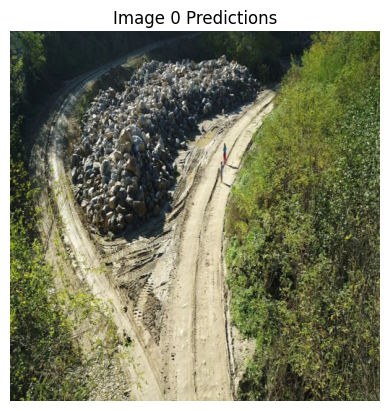

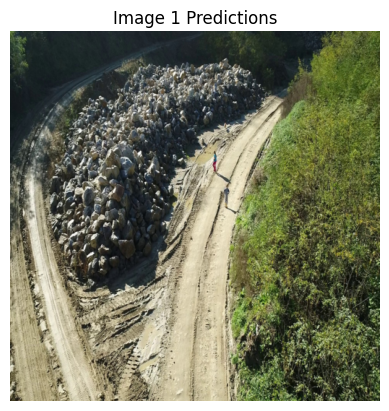

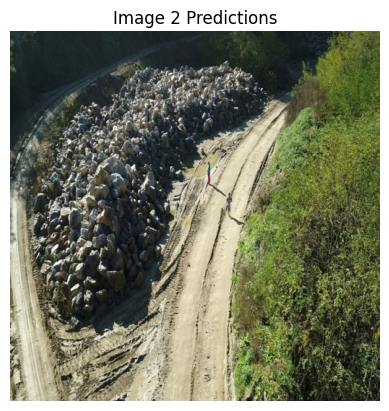

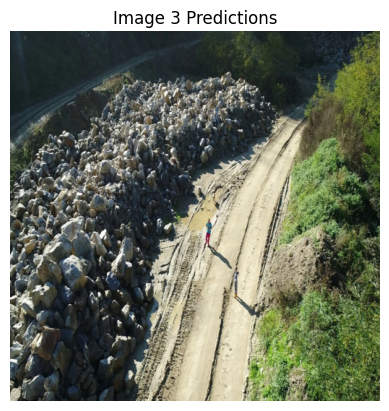

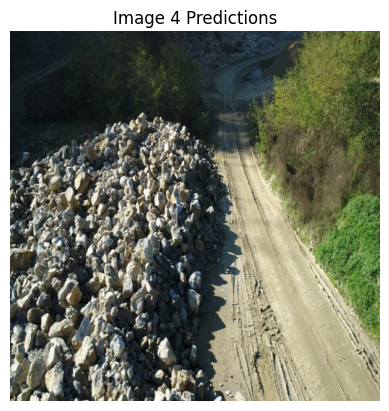

In [ ]:
model.eval()

THRESHOLD = 0.3
MAX_IMAGES = 5
images_shown = 0

for idx, (imgs, targets) in enumerate(test_loader):
  imgs_tensor = torch.stack([img.to(DEVICE) for img in imgs])
  with torch.no_grad():
    outputs = model(imgs_tensor)

  for i, output in enumerate(outputs):
    if images_shown >= MAX_IMAGES:
      break  # this break is just to get out of the inner loop, there is no better way without break

    img = imgs[i].permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)

    boxes = output[:, :4].cpu().numpy()
    scores = output[:, 4].cpu().numpy()
    labels = output[:, 5].cpu().numpy().astype(int)

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for box, score, label in zip(boxes, scores, labels):
      if score >= THRESHOLD:
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, f'Score: {score:.2f}', color='yellow', fontsize=8, backgroundcolor='black')

    plt.title(f'Image {images_shown} Predictions')
    plt.axis('off')
    plt.show()

    images_shown += 1

  if images_shown >= MAX_IMAGES:
    break  # Is needed to get out of the outer loop as well (can't be removed without overcomplicating it)

We observe that the performance of EfficientDet D0 is poor from every perspective. Although it was necessary to resize the images beforehand, it still does not achieve good results.
This model should be ruled out, but we will test the performance of the D1 version to determine whether the entire model should be excluded or only the D0 variant.

### EfficientDet D1

In [ ]:
src = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_EfficientDet_D1'
dst = '/content/AERALIS_EfficientDet_D1_local'

# Delete the destination if it already exists (shutil.rmtree), then recopy from scratch
if os.path.exists(dst):
  shutil.rmtree(dst)
shutil.copytree(src, dst)
print("Copy completed")

Copy completed


In [ ]:
!df -h / # It shows the total, used and free space on the root (/) of the Colab VM.

# Avail column: space still available for your files.

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   67G   47G  59% /


In [ ]:
# Show space used by your local folder
!du -sh /content/AERALIS_EfficientDet_D0_local

6.6G	/content/AERALIS_EfficientDet_D0_local


In [ ]:
# Show space occupied by various folders in /content/.
!du -h --max-depth=1 /content/

140K	/content/.config
du: cannot access '/content/drive/.Encrypted/.shortcut-targets-by-id/1LQbD7p_iS5KLqGNdfrYEvsAx0i_bgB0h/projectUPV': No such file or directory
71G	/content/drive
6.6G	/content/AERALIS_EfficientDet_D0_local
6.6G	/content/AERALIS_EfficientDet_D1_local
55M	/content/sample_data
84G	/content/


In [ ]:
# Main parameters
BASE_DIR = dst
VARIANT = 'tf_efficientdet_d1'  # Change to 'd0' or 'd2' for other versions
IMAGE_SIZE = 640                # D0=512, D1=640, D2=768
NUM_CLASSES = 1                 # only one class (ex: 'person')
BATCH_SIZE = 16
EPOCHS = 100
PATIENCE = 20
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# To see the available GPU
print(torch.cuda.is_available()) # True = you have GPU --> if False then use device='cpu'
print(torch.cuda.device_count()) # Name of GPU

# If True and at least 1, you can use device=0.
# If you don't have GPU: use device='cpu' (much slower).
# Locally (not Colab): check with nvidia-smi from terminal.

True
1


In [ ]:
class CocoDetectionTransformed(CocoDetection):
  def __init__(self, img_folder, ann_file, transform=None):
    super().__init__(img_folder, ann_file)
    self.transform = transform

    # Build a set of image ids that have annotations with bbox area > 0
    valid_img_ids = set()
    for ann in self.coco.dataset['annotations']:
      if ann['bbox'][2] > 1 and ann['bbox'][3] > 1:  # bbox width & height > 1 pixel
        valid_img_ids.add(ann['image_id'])

    # Find dataset indices corresponding to valid image ids
    self.valid_indices = []
    for i, img_info in enumerate(self.coco.dataset['images']):
      if img_info['id'] in valid_img_ids:
        self.valid_indices.append(i)

  def __len__(self):
    return len(self.valid_indices)

  def __getitem__(self, idx):
    real_idx = self.valid_indices[idx]
    img, target = super().__getitem__(real_idx)
    if self.transform is not None:
      img = self.transform(img)
    return img, target

In [ ]:
# COCO DataLoader Function
def get_loader(img_dir, ann_path, shuffle):
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Ensures that all images are the same size
        transforms.ToTensor()
    ])
    ds = CocoDetectionTransformed(img_dir, ann_path, transform=transform)
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle,
                      collate_fn=lambda x: tuple(zip(*x)), num_workers=2)

# collate_fn allows for variable object batches (e.g., several boxes per image)

In [ ]:
# COCO DataLoader Function for inference (con Resize per matchare training)
def get_loader_test(img_dir, ann_path):
  transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
  ])
  ds = CocoDetectionTransformed(img_dir, ann_path, transform=transform)
  return DataLoader(ds, batch_size=1, shuffle=False,
                    collate_fn=lambda x: tuple(zip(*x)), num_workers=2)

In [ ]:
# Loading the 3 sets (train, val, test):
train_loader = get_loader(f'{BASE_DIR}/train/images', f'{BASE_DIR}/annotations_train.json', True)
val_loader   = get_loader(f'{BASE_DIR}/val/images', f'{BASE_DIR}/annotations_val.json', False)
test_loader = get_loader_test(f'{BASE_DIR}/test/images', f'{BASE_DIR}/annotations_test.json')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# Model initialization
config = get_efficientdet_config(VARIANT) # load configuration for tf_efficientdet_d0
config.num_classes = NUM_CLASSES # sets the number of classes
config.image_size = (IMAGE_SIZE, IMAGE_SIZE) # sets the image size
# config.image_size = None # This tells the model to accept input of any size and apply the correct resizing internally
net = EfficientDet(config, pretrained_backbone=True) # Initialize the model (use pre-trained backbone)
# net = EfficientDet(config)
net.class_net = HeadNet(config, num_outputs=NUM_CLASSES) # Create the classifier (HeadNet)
model = DetBenchTrain(net, config).to(DEVICE) # He wraps it in a training module
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4) # Use AdamW optimizer

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

In [ ]:
# Early stopping setup:
epoch = 0
epochs_no_improve = 0  # Count how many epochs passed without validation improvement
best_loss = float('inf')  # Best (minimal) validation loss so far
best_model_path = f'effdet_{VARIANT}_best.pth' # File to save best weights

# Training loop
while epoch < EPOCHS and epochs_no_improve < PATIENCE:
    model.train()  # Training mode
    total_loss = 0.0  # Sum of training losses this epoch

    for images, targets in train_loader:
        images = torch.stack([img.to(DEVICE) for img in images])

        boxes = []
        labels = []

        for t in targets:
            b = []
            l = []
            for obj in t:
                x, y, w, h = obj['bbox']
                if w > 1 and h > 1:  # Filter invalid bboxes
                    x1, y1 = x, y
                    x2, y2 = x + w, y + h
                    b.append([x1, y1, x2, y2])
                    l.append(0)  # Class index (0 for single class)

            b = torch.tensor(b, dtype=torch.float32)
            l = torch.tensor(l, dtype=torch.int64)
            boxes.append(b.to(DEVICE))
            labels.append(l.to(DEVICE))

        img_sizes = torch.tensor([[IMAGE_SIZE, IMAGE_SIZE]] * len(images), device=DEVICE)
        img_sizes = torch.tensor([[img.shape[1], img.shape[2]] for img in images], device=DEVICE)
        img_scales = torch.ones(len(images), device=DEVICE)

        # Forward pass and loss calculation
        loss_dict = model(images, {
            'bbox': boxes,
            'cls': labels,
            'img_scale': img_scales,
            'img_size': img_sizes
        })
        loss = loss_dict['loss']

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        print(f"[Epoch {epoch}] Batch loss: {loss.item()}")

    # Validation phase
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, targets in val_loader:
            images = torch.stack([img.to(DEVICE) for img in images])

            boxes = []
            labels = []

            for t in targets:
                b = []
                l = []
                for obj in t:
                    x, y, w, h = obj['bbox']
                    if w > 1 and h > 1:
                        x1, y1 = x, y
                        x2, y2 = x + w, y + h
                        b.append([x1, y1, x2, y2])
                        l.append(0)
                b = torch.tensor(b, dtype=torch.float32)
                l = torch.tensor(l, dtype=torch.int64)
                boxes.append(b.to(DEVICE))
                labels.append(l.to(DEVICE))

            img_sizes = torch.tensor([[IMAGE_SIZE, IMAGE_SIZE]] * len(images), device=DEVICE)
            img_sizes = torch.tensor([[img.shape[1], img.shape[2]] for img in images], device=DEVICE)
            img_scales = torch.ones(len(images), device=DEVICE)

            loss_dict = model(images, {
                'bbox': boxes,
                'cls': labels,
                'img_scale': img_scales,
                'img_size': img_sizes
            })
            loss = loss_dict['loss']

            if not torch.isnan(loss):
                val_loss += loss.item()
            else:
                print("NaN detected in loss, batch skipped.")

    avg_val_loss = val_loss / len(val_loader)
    print(f"[Epoch {epoch+1}/{EPOCHS}] Val loss: {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        epochs_no_improve = 0
        print("Best saved model.")
    else:
        epochs_no_improve += 1
        print(f"Epochs without improvement: {epochs_no_improve}/{PATIENCE}")

    epoch += 1

# Training end reason
if epochs_no_improve >= PATIENCE:
    print("Early stopping enabled.")
else:
    print("End of training: reached maximum number of epochs.")

[Epoch 0] Batch loss: 1740.4906005859375
[Epoch 0] Batch loss: 1000.155517578125
[Epoch 0] Batch loss: 793.8364868164062
[Epoch 0] Batch loss: 1553.92333984375
[Epoch 0] Batch loss: 1954.9256591796875
[Epoch 0] Batch loss: 864.85888671875
[Epoch 0] Batch loss: 1260.31005859375
[Epoch 0] Batch loss: 1067.719482421875
[Epoch 0] Batch loss: 996.4481201171875
[Epoch 0] Batch loss: 1188.4664306640625
[Epoch 0] Batch loss: 932.6137084960938
[Epoch 0] Batch loss: 3621.905517578125
[Epoch 0] Batch loss: 1102.611083984375
[Epoch 0] Batch loss: 1395.2674560546875
[Epoch 0] Batch loss: 1326.29248046875
[Epoch 0] Batch loss: 2612.218017578125
[Epoch 0] Batch loss: 690.36328125
[Epoch 0] Batch loss: 1105.428955078125
[Epoch 0] Batch loss: 1684.157958984375
[Epoch 0] Batch loss: 1527.9671630859375
[Epoch 0] Batch loss: 909.2998046875
[Epoch 0] Batch loss: 977.86083984375
[Epoch 0] Batch loss: 1512.1474609375
[Epoch 0] Batch loss: 1865.0340576171875
[Epoch 0] Batch loss: 1739.98974609375
[Epoch 0] Ba

In [ ]:
!mkdir -p /content/drive/MyDrive/projectUPV/datasets/AERALIS_EfficientDet_D1/weights

In [ ]:
weights_dir = '/content/drive/MyDrive/projectUPV/datasets/AERALIS_EfficientDet_D1/weights'
os.makedirs(weights_dir, exist_ok=True)
shutil.copy(best_model_path, weights_dir)
print("EfficientDet weights copied to Google Drive.")

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/projectUPV/datasets/AERALIS_EfficientDet_D1/weights/effdet_tf_efficientdet_d1_best.pth'))

In [ ]:
config = get_efficientdet_config(VARIANT)
config.num_classes = NUM_CLASSES
config.image_size = (IMAGE_SIZE, IMAGE_SIZE)

net = EfficientDet(config, pretrained_backbone=False)
net.class_net = HeadNet(config, num_outputs=NUM_CLASSES)

model = DetBenchPredict(net).to(DEVICE)
model.load_state_dict(torch.load(best_model_path))
model.eval()

In [ ]:
# Inference on complete test set
predictions = []

with torch.no_grad():  # disable gradient calculation
  for batch_idx, (imgs, targets) in enumerate(test_loader):  # iterate over test batches
    imgs = torch.stack([i.to(DEVICE) for i in imgs])  # move images to device as batch tensor
    outputs = model(imgs)  # run inference

    for i, output in enumerate(outputs):  # process predictions for each image in batch
      global_index = batch_idx * len(imgs) + i  # compute global image index

      # default: assume image ID is None (invalid)
      img_id = None
      if global_index < len(test_loader.dataset.ids):
        img_id = test_loader.dataset.ids[global_index]

      # skip if ID is missing or output is invalid
      if img_id is None:
        print(f"[WARNING] Image index {global_index} has no valid ID")
      elif output.ndim != 2 or output.shape[1] != 6:
        print(f"[WARNING] Invalid output for image {img_id}")
      else:
        # valid output format: [x1, y1, x2, y2, score, label]
        boxes = output[:, :4].cpu().numpy()
        scores = output[:, 4].cpu().numpy()
        labels = output[:, 5].cpu().numpy().astype(int)

        print(f"[INFO] Processed image {img_id} with {len(boxes)} predictions.")

        # save predictions in COCO-compatible format
        for box, score, label in zip(boxes, scores, labels):
          # Restore original image dimensions
          orig_w = test_loader.dataset.coco.imgs[img_id]['width']
          orig_h = test_loader.dataset.coco.imgs[img_id]['height']

          # Scale factors to return to the original resolution
          scale_x = orig_w / IMAGE_SIZE
          scale_y = orig_h / IMAGE_SIZE

          x1, y1, x2, y2 = box
          x1 *= scale_x
          x2 *= scale_x
          y1 *= scale_y
          y2 *= scale_y

          predictions.append({
            "image_id": img_id,
            # "category_id": int(label),
            "category_id": int(label) + 1,
            "bbox": [x1, y1, x2 - x1, y2 - y1],
            "score": float(score)
          })

# Final status
print(f"\nInference completed. Total predictions collected: {len(predictions)}")

In [ ]:
# Convert all fields to native Python types
for pred in predictions:
    pred["category_id"] = int(pred["category_id"])
    pred["image_id"] = int(pred["image_id"])
    pred["score"] = float(pred["score"])
    pred["bbox"] = [float(x) for x in pred["bbox"]]

# Save to COCO-style JSON
with open("results_coco.json", "w") as f:
    json.dump(predictions, f)

In [ ]:
# Load file
with open(f"{BASE_DIR}/annotations_test.json", "r") as f:
  data = json.load(f)

# Add missing "info" field if not present
if "info" not in data:
  data["info"] = {
    "description": "My Custom Dataset for Object Detection",
    "version": "1.0",
    "year": 2025,
    "contributor": "Daniele Pavan",
    "date_created": "2025-07-22"
  }

# Save back
with open(f"{BASE_DIR}/annotations_test.json", "w") as f:
  json.dump(data, f)

In [ ]:
# Load ground truth annotations
coco_gt = COCO(f"{BASE_DIR}/annotations_test.json")

# Load predictions from file (as a list)
with open("results_coco.json", "r") as f:
    results = json.load(f)

# Ensure values are native Python types
for pred in results:
    pred["category_id"] = int(pred["category_id"])
    pred["image_id"] = int(pred["image_id"])
    pred["score"] = float(pred["score"])
    pred["bbox"] = [float(x) for x in pred["bbox"]]

# Load predictions into COCO format from list (not from file path!)
coco_dt = coco_gt.loadRes(results)

# Run COCO evaluation
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

In [ ]:
model.eval()

THRESHOLD = 0.3
MAX_IMAGES = 5
images_shown = 0

for idx, (imgs, targets) in enumerate(test_loader):
  imgs_tensor = torch.stack([img.to(DEVICE) for img in imgs])
  with torch.no_grad():
    outputs = model(imgs_tensor)

  for i, output in enumerate(outputs):
    if images_shown >= MAX_IMAGES:
      break  # this break is just to get out of the inner loop, there is no better way without break

    img = imgs[i].permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)

    boxes = output[:, :4].cpu().numpy()
    scores = output[:, 4].cpu().numpy()
    labels = output[:, 5].cpu().numpy().astype(int)

    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for box, score, label in zip(boxes, scores, labels):
      if score >= THRESHOLD:
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-5, f'Score: {score:.2f}', color='yellow', fontsize=8, backgroundcolor='black')

    plt.title(f'Image {images_shown} Predictions')
    plt.axis('off')
    plt.show()

    images_shown += 1

  if images_shown >= MAX_IMAGES:
    break  # Is needed to get out of the outer loop as well (can't be removed without overcomplicating it)

### EfficientDet D2

### MobileNetV2 + SSDLite

### MobileNetV3 + SSDLite

# Normalization and Data Augmentation

Per i modelli leggeri ottimizzati come quelli per Jetson Nano, la normalizzazione delle immagini è quasi sempre richiesta prima di passarle al modello.

I modelli in PyTorch lavorano SOLO con tensori, NON con immagini PIL o array NumPy.
- ToTensor() converte un’immagine (PIL o NumPy) in un tensore PyTorch di tipo float32, formato [C, H, W] (canale, altezza, larghezza).

- Inoltre, scala i valori dei pixel da [0,255] a [0,1] automaticamente.

La normalizzazione (Normalize) funziona SOLO su tensori.
La funzione Normalize(mean, std) richiede input già in formato tensore (float) e applica lo shift/scala canale per canale.

Se provi a normalizzare un’immagine PIL o un NumPy array direttamente, ottieni errore o comportamenti inattesi.

Quindi: la sequenza è SEMPRE
(Opzionale) Resize

ToTensor()   →  Converte e scala [0,255] in [0,1]

Normalize()  →  Normalizza ogni canale secondo mean/std richiesto dal modello


\
 In sintesi:
ToTensor è indispensabile, non è solo per PyTorch, ma anche perché la normalizzazione funziona SOLO su tensori, non su immagini raw!

La normalizzazione NON sostituisce ToTensor: lavora sopra i dati già convertiti.

La sequenza ToTensor() + normalizzazione è quasi sempre necessaria, ma i dettagli della normalizzazione (mean, std, range pixel) possono cambiare in base al modello.
Vediamo la situazione per i tuoi modelli:
-


# Fine-Tuning Models (Alexia)

Analizzo il codice di Alexia per avere uno spunto:

1. test_comptage_img.py
Scopo:
Carica un modello YOLO addestrato e conta quanti oggetti della classe 0 (qui chiamati "oiseaux" = uccelli, ma tu potresti adattare a "persone") vengono rilevati in una singola immagine.

In [ ]:
from ultralytics import YOLO # Importa la libreria Ultralytics YOLO

# Chargement du modèle entraîné
model = YOLO("../runs/detect/train4/weights/best.pt") # Carica il modello YOLO addestrato dal file best.pt (specificare il percorso giusto)

# Prédiction sur une image
results = model.predict("test4.jpeg") # Esegue la predizione sull'immagine "test4.jpeg"

# Compte des oiseaux (classe 0)
bird_count = sum(1 for cls in results[0].boxes.cls if int(cls) == 0) # Conta quante bounding box appartengono alla classe 0

print(f"Nombre d'oiseaux : {bird_count}") # Stampa il numero di oggetti (classe 0) rilevati


Nota:

Puoi cambiare "classe 0" con "persona" se il tuo modello rileva persone come classe 0.

2. test_comptage_video.py
Scopo:
Carica un modello YOLO addestrato, effettua il tracking (con ByteTrack) e conta quanti oggetti della classe 0 ("oiseaux") entrano in un rettangolo centrale all'interno di un video.
Annota la video con bounding box, ID, conta corrente e totale degli oggetti unici che sono entrati nel rettangolo.

In [ ]:
from ultralytics import YOLO                # Importa YOLO da Ultralytics
import cv2                                  # Importa OpenCV per gestione video e immagini
import os                                   # Importa os (qui non usato, ma spesso per path)

# Charger le modèle
model = YOLO("/Users/alexiagaido--amoros/Desktop/UPV-test/entrainement_serveur/runs/detect/train9/weights/best.pt")
# Carica il modello YOLO addestrato (specifica percorso)

# Chemin de la vidéo
video_path = "img_video/video_test_1.mp4"   # Path della video da analizzare
output_path = "output_video.mp4"            # Path della video annotata in output

# Distance des bords pour le rectangle de contact (en pixels)
border_distance = 50                        # Margine dai bordi (pixels) per il rettangolo centrale

# Ouvrir la vidéo
cap = cv2.VideoCapture(video_path)          # Apre la video
if not cap.isOpened():
    print("Erreur : Impossible d'ouvrir la vidéo")   # Se non apre la video, errore
    exit()

# Obtenir les propriétés de la vidéo
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))       # Ottiene larghezza frame
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))     # Ottiene altezza frame
fps = int(cap.get(cv2.CAP_PROP_FPS))                # Ottiene fps

# Définir les coordonnées du rectangle de contact
rect_x1 = border_distance                           # Coordinate x1 del rettangolo
rect_y1 = border_distance                           # Coordinate y1
rect_x2 = width - border_distance                   # Coordinate x2
rect_y2 = height - border_distance                  # Coordinate y2

# Configurer la sortie vidéo
fourcc = cv2.VideoWriter_fourcc(*"mp4v")            # Codec video per output
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))  # Oggetto per scrivere la video annotata

# Ensemble pour stocker les IDs uniques des oiseaux dans le rectangle
unique_bird_ids = set()                             # Insieme per salvare gli ID unici degli oggetti che sono passati nel rettangolo

while cap.isOpened():
    ret, frame = cap.read()                         # Leggi un frame
    if not ret:
        break

    # Effectuer l'inférence avec suivi
    results = model.track(frame, conf=0.5, tracker="bytetrack.yaml", persist=True)
    # Fa inferenza + tracking, usa ByteTrack, restituisce risultati con ID di tracking

    # Compter les oiseaux dans cette frame
    bird_count = 0
    if results[0].boxes.id is not None:             # Se ci sono ID di tracking
        for box, box_id in zip(results[0].boxes, results[0].boxes.id):   # Scorri bounding box e relativi ID
            # Vérifier si le centre de la bounding box est dans le rectangle
            x_center = (box.xyxy[0][0] + box.xyxy[0][2]) / 2            # Calcola centro x
            y_center = (box.xyxy[0][1] + box.xyxy[0][3]) / 2            # Calcola centro y
            if rect_x1 < x_center < rect_x2 and rect_y1 < y_center < rect_y2:   # Se centro box dentro rettangolo centrale
                unique_bird_ids.add(box_id.item())                      # Aggiungi ID a set (oggetti unici che sono passati)
                bird_count += 1                                         # Conta per questa frame

    # Annoter l'image avec les détections et IDs
    annotated_frame = results[0].plot()              # Disegna box e ID sul frame

    # Dessiner le rectangle de contact
    cv2.rectangle(
        annotated_frame,
        (rect_x1, rect_y1),
        (rect_x2, rect_y2),
        (255, 0, 0),  # Blu
        2,            # Spessore linea
    )

    # Afficher le nombre d'oiseaux dans cette frame et le total unique
    cv2.putText(
        annotated_frame,
        f"Oiseaux dans cette frame : {bird_count}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),  # Verde
        2,
    )
    cv2.putText(
        annotated_frame,
        f"Oiseaux uniques : {len(unique_bird_ids)}",
        (10, 60),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,
        (0, 255, 0),
        2,
    )

    # Écrire l'image annotée dans la vidéo de sortie
    out.write(annotated_frame)

    # Afficher l'image en temps réel
    cv2.imshow("YOLO Tracking", annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):  # Premere 'q' per uscire
        break

# Afficher le total des oiseaux uniques détectés
print(f"Nombre total d'oiseaux uniques détectés dans la vidéo : {len(unique_bird_ids)}")

# Libérer les ressources
cap.release()
out.release()
cv2.destroyAllWindows()

Considerazioni tecniche
Classe 0: Il codice è pensato per oggetti "oiseaux" (uccelli) = classe 0. Se tu hai persone come classe 0, funziona identico.

Tracking (ByteTrack): Permette di assegnare un ID a ogni oggetto/persona che attraversa l’area, così da contarli solo una volta anche se si fermano/muovono nella scena.

Rettangolo di interesse: Conta solo gli oggetti il cui centro entra in una zona centrale, utile ad esempio per contare solo chi passa in una certa area (adattabile per ingressi, uscite, ecc).

Salvataggio video annotato: Il risultato è un video con box, ID e conteggi stampati sopra.